In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 

import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [3]:
# mas output - br, rho, vr
cr = "2200"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)

['bp', 'br', 'bt', 'p', 'rho', 't', 'vp', 'vr', 'vt']


In [76]:
pp, tt, rr = np.meshgrid(p, model["vp"].theta_coords, model["vp"].r_coords, indexing='ij')
coordinate_grid = np.array([pp.T, tt.T, rr.T]).T

# linear interpolation
interp_function = RegularGridInterpolator(points=(model["vt"].phi_coords, model["vt"].theta_coords, model["vt"].r_coords),
                                          values=np.array(model["vt"].data), bounds_error=False, fill_value=None)

f_P_newgrid = interp_function(coordinate_grid)



In [77]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = model["vr"].phi_coords
# number of phi indexes 
n_p = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = model["vr"].theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (model["vr"].r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]




# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi)

In [78]:
vr = model["vr"].data
vr = np.append(vr,[vr[0, :, :]],axis=0)

vp = model["vp"].data
vp = np.append(vp,[vp[0, :, :]],axis=0)

vt = model["vt"].data
vt = np.append(vt,[vt[0, :, :]],axis=0)

rho = model["rho"].data
rho = np.append(rho,[rho[0, :, :]],axis=0)

Pr = model["p"].data
Pr = np.append(Pr,[Pr[0, :, :]],axis=0)

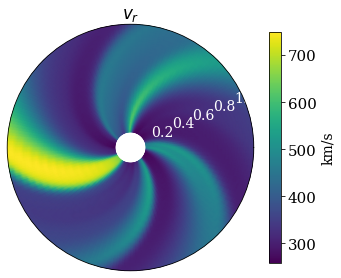

In [79]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, vr[:, 55, :].T, shading='gouraud', cmap="viridis")
ax.set_title("$v_{r}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vr.png", dpi=600)

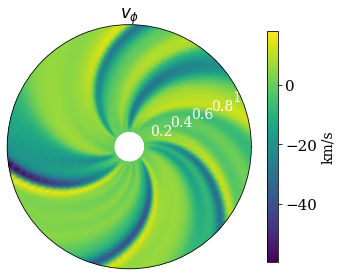

In [80]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, vp[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$v_{\phi}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vp.png", dpi=600)

TypeError: Dimensions of C (141, 129) are incompatible with X (129) and/or Y (140); see help(pcolormesh)

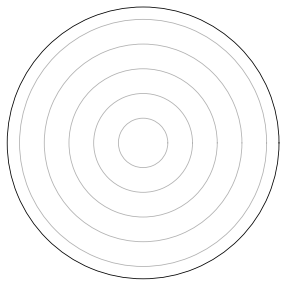

In [84]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, f_P_newgrid[:, 55, :].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$v_{\theta}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vt.png", dpi=600)

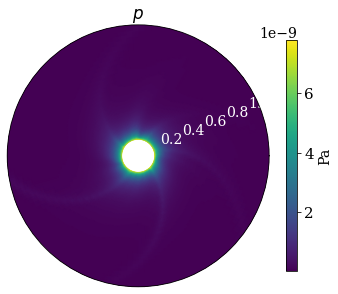

In [82]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, Pr[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$p$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'Pa', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/p.png", dpi=600)

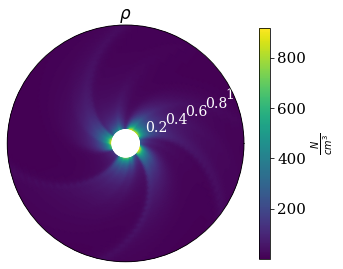

In [83]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, rho[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$\rho$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'$\frac{N}{cm^3}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/rho.png", dpi=600)

# Initialize

In [ ]:
gamma = 5/3
omega_rot = (2 * np.pi) / (25.38 * 86400)


q0 = np.vstack((vr[:, :, 0], rho[:, :, 0], Pr[:, :, 0], vp[:, :, 0], vt[:, :, 0]))